# Kafka개요

## 1.Kafka

### 기능
* Kafka는 발행-구독 모델을 지원하는 분산 메시지 큐
* 큰 데이터 볼륨 처리를 위해 여러 대의 서버로 안정성과 확장성을 확보할 수 있도록 클러스터로 구성
* 토픽(topic)을 중심으로 프로듀서(producer)라고 하는 발행자와 컨슈머(consumer)라고 하는 구독자로 데이터 처리
* 하나의 토픽을 여러 개의 파티션(partition)으로 확장 가능
* producer API, consumer API 뿐만 아니라 Kafka Streams, Kafka Connector 등의 라이브러리를 바탕으로 탄력적으로 스트리밍 데이터를 처리할 수 있도록 지원

### 개념
* Kafka는 고성능 TCP 네트워크 프로토콜을 통해 통신하는 서버와 클라이언트로 구성된 분산 시스템
* 서버
    - Kafka는 하나 이상의 서버로 구성된 클러스터
    - 서버 중 일부는 브로커라고 하는 스토리지 계층을 형성
    - 그 외에 다른 서버는 Kafka Connect를 통해 데이터를 스트리밍하면서 Kafka를 다른 시스템(RDBMS, 다른 Kafka 클러스터 등)과 통합
* 클라이언트
    - 메시지의 발행자(producer)와 구독자(consumer)에 해당
    - 장애 발생시에도 고가용성을 보장하면서 이벤트 스트림을 병렬적으로 처리할 수 있는 분산 애플리케이션 및 마이크로서비스 작성 가능

### 토픽과 파티션

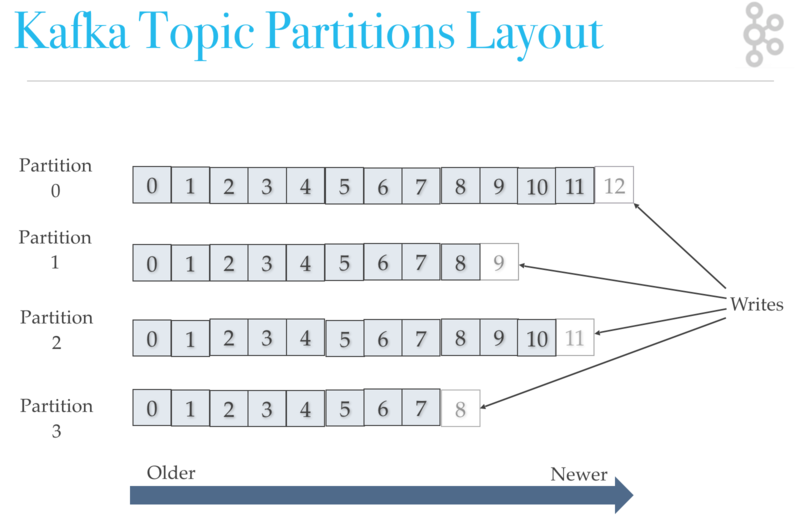

* 토픽(Topic)
    - Kafka의 메시지가 저장되는 공간
    - 토픽은 데이터베이스의 테이블이나 파일 시스템의 폴더와 유사
    - 일반적으로 파티션의 갯수와 상관없이 하나의 토픽을 스트림으로 간주
* 파티션(Partition)
    - 하나의 토픽은 여러 개의 파티션으로 구성
    - 메시지는 파티션에 추가되는 형태로만 수록, 맨 앞에서부터 제일 끝 까지의 순서로 읽힘
    - 메시지 처리 순서는 토픽이 아닌, 파티션 별로 유지 및 관리
    - 추가되는 메시지는 여러 개의 파티션 중 하나의 끝에 수록
    - 파티션들은 서로 다른 서버에 분산될 수 있다. = 하나의 토픽이 여러 서버에 걸쳐 수평적으로 확장될 수 있음<br>
    -> 단일 서버로 처리할 때보다 성능이 우수

### 프로듀서와 컨슈머

* Kafka 클라이언트는 기본적으로 프로듀서와 컨슈머(구독자, consumer)라는 두 가지형태를 지님
* 프로듀서(발행자, producer): 새로운 메시지를 생성(발행)
* 컨슈머(구독자, consumer)
    - 하나 이상의 토픽을 구독하여 메시지가 생성된 순서로 읽음
    - 메시지의 offset을 유지하여 읽는 메시지의 위치를 알 수 있다.
* offset
    - 파티션 내에서의 고유한 순서정보를 가진 식별자로 각 해다 파티션에 속한 레코드(메시지)별로 할당됨
    - 변경 불가능한 숫자로 Kafka에서 관리하며 무한대로 증가(정수)
    - offset 값 순서는 해당 파티션 내에서만 보장(토픽 전체에서는 보장되지 않음)
    - Zookeeper나 kafka는 마지막으로 읽은 메시지의 offset을 저장하고 있으므로 컨슈머가 메시지 읽기를 중단했다 다시 시작하더라도 마지막 위치에서부터 읽을수 있다.

### 브로커와 클러스터
* 브로커(broker)
    - 하나의 Kafka 서버
    - 프로듀서로부터 메시지를 수신하고, 오프셋을 지정한 후 해당 메시지를 디스크에 저장
    - 컨슈머의 파티션 읽기 요청에 응답하여 디스크에 수록된 메시지를 전송
    - 시스템 하드웨어 성능에 따라 다르겠지만, 보통 하나의 브로커는 초당 수천개의 토픽과 수 백만개의 메시지 처리 가능
    - 각 파티션은 클러스터의 한 브로커가 소유하며, 이 브로커를 해당 파티션의 리더(leader)라고 함
    - 같은 파티션이 여러 브로커에 지정될 수도 있는데, 이러한 경우 리더 브로커에서 해당 파티션을 복제(relication)
    - 아래 그림 예시: Replication factor=3이므로 같은 리더(Partition 0)에서 Partition을 2개 더 복제(Partition 0, R1 & Partition 0, R2)하여 해당 브로커에 저장
    
    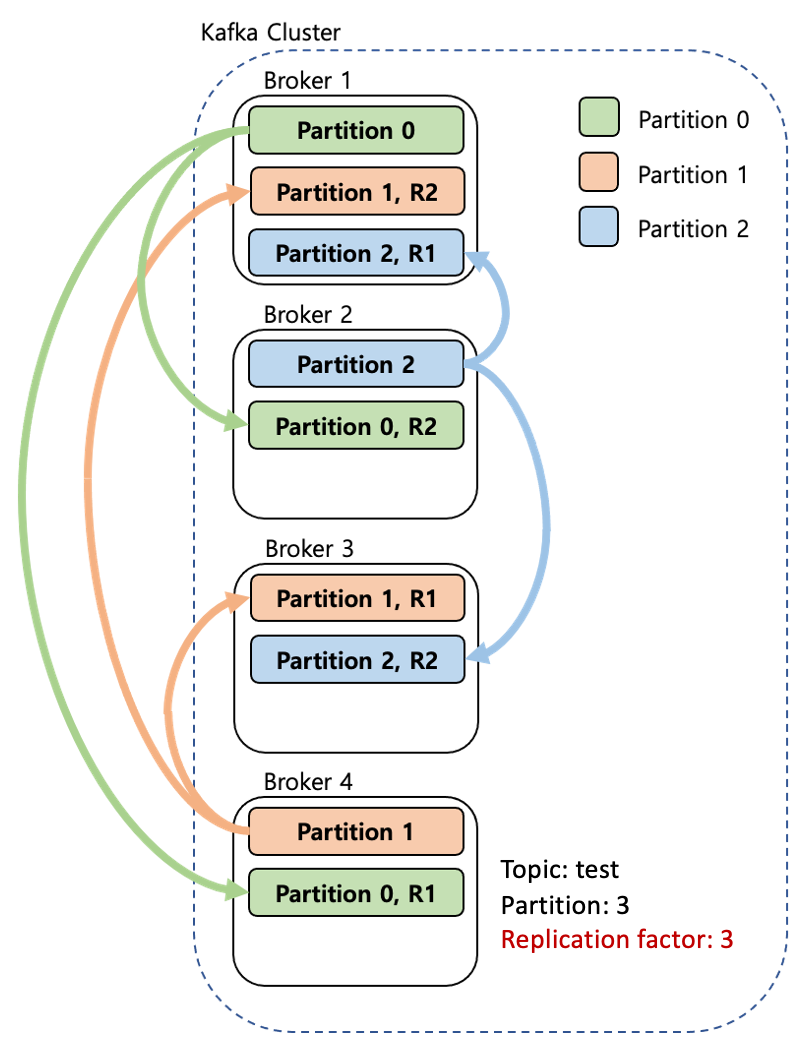
    
    - 이러한 경우 해당 파티션은 클러스터 내 중복으로 저장되지만, 리더 브로커에 장애가 생기면 다른 브로커가 소유권을 인계받아 해당 파티션을 처리할 수 있다.

* 클러스터(cluter)
    - 클러스터는 여러개의 브로커로 구성
    - 그 중 하나를 자동으로 선정하여 클러스터 컨트롤러(controller)기능을 수행
        - 같은 클러스터 내 각 브로커에게 담당 파티션을 할당
        - 클러스터 내 브로커들이 정상적으로 동작하는지 모니터링(클러스터 관리)

#  Kafka 구축하기

## 1. 설치 개요

* Zookeeper와 Kafka는 Java로 작성되었으므로 클러스터 구축 전 Java 설치 필요
* 각 가상머신별로 다음과 같이 서버 설치

|호스트명|설치 내용|Processors|Memory|Storage|OS|
|---|---|---|---|---|---|
|master|[HDFS] NameNode <br> [YARN] ResourceManager <br> [MapReduce] Job History Server <br> [Spark] Master <br> [Spark] HistoryServer <br> [Zookeeper] Server <br> [Kafka] Brocker|4|8GB|60GB|Ubuntu 20.04|
|worker01|[HDFS] SecondaryNameNode <br> [HDFS] DataNode <br> [YARN] NodeManager <br> [Spark] Worker|2|4GB|60GB|Ubuntu 20.04|


* 설치 전 마스터에 다음의 패키지 설치

In [ ]:
sudo apt install net-tools

## 2. Zookeeper 설치

* master에 3.8.1버전(2023년 6월 기준 최신) Zookeeper 다운로드

In [ ]:
# Zookeeper 다운로드
# Downloads 디렉토리로 이동 후 다운로드 수행
wget wget https://dlcdn.apache.org/zookeeper/zookeeper-3.8.1/apache-zookeeper-3.8.1-bin.tar.gz

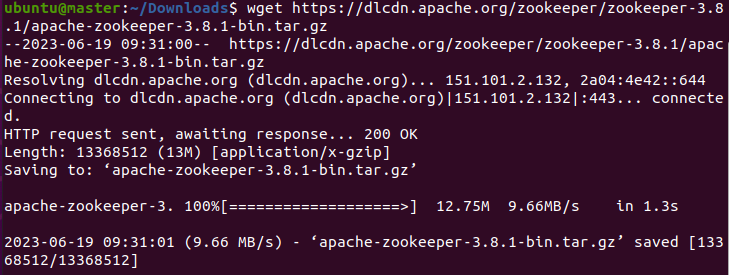

* 압축 해제 및 파일 이동

In [ ]:
# 압축 해제
tar -xf apache-zookeeper-3.8.1-bin.tar.gz

# 파일 이동
sudo mv apache-zookeeper-3.8.1-bin /usr/local/zookeeper

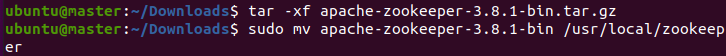

* 사용자 환경변수 설정

In [ ]:
# 디렉토리 이동
cd /usr/local

# 환경변수 설정
echo "export ZOOKEEPER_HOME=/usr/local/zookeeper" >> ~/.bashrc
source ~/.bashrc

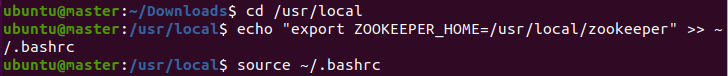

* $ZOOKEEPER_HOME/conf 디렉토리 내 zoo.cfg파일을 생성하여 설정 파라미터 작성

In [ ]:
echo "tickTime=2000" > /usr/local/zookeeper/conf/zoo.cfg
echo "dataDir=/usr/local/zookeeper/data" >> /usr/local/zookeeper/conf/zoo.cfg
echo "clientPort=2181" >> /usr/local/zookeeper/conf/zoo.cfg

* tickTime: Zookeeper에서 사용하는 기본 시간 단위(밀리초)
    - Zookeeper도 Hadoop, Spark와 마찬가지로 heartbeat를 통하여 피어 서버(노드)들의 상태들을 확인하며, 이는 설정한 tickTime에 따라 작동함<br>
    -> leader가 follower에게 ping을 발송, follower가 이에 대한 응답으로 자신의 상태를 알림<br>
    -> 만약 정해진 시간 내 응답을 받지 못하면 해당 follower에 장애가 발생한 것으로 간주, 조치에 들어감
    - 세션 timeout시간의 경우 지정한 tickTime의 2배로 설정됨
* dataDir: 인메모리 데이터베이스의 스냅샷, (별도로 지정하지 않을 시) 데이터베이스 업데이트시 트랜젝션 로그, 피어서버들의 상태 등을 저장하는 디렉토리 지정
* clientPort: 클라이언트에서 Zookeeper서비스에 연결하는데 사용하는 포트 설정

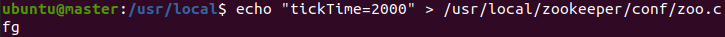

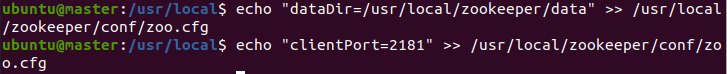

* 환경변수 확인

In [ ]:
# 환경변수 오타유무 확인
cd zookeeper/conf
vi zoo.cfg

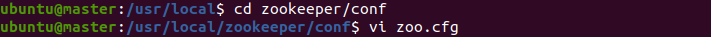

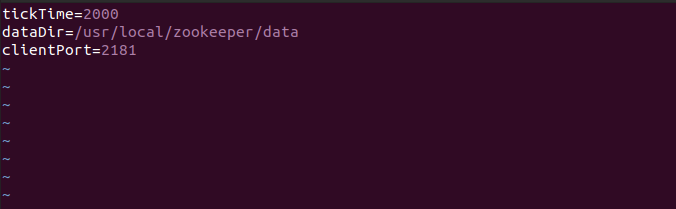

In [ ]:
# 추가 설정 진행
# zoo.cfg 에서 dataDir로 지정한 /usr/local/zookeeper/data 디렉토리 생성
cd $ZOOKEEPER_HOME
mkdir data

# data폴더 내 myid 파일을 생성하여
# zoo.cfg의 server명 나열 시 명시한 서버의 고유 ID(x) 작성
echo 1 > /usr/local/zookeeper/data/myid

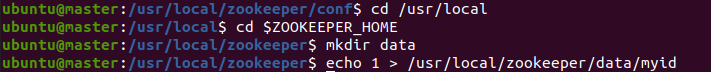

## 3. Kafka 설치

* master에 scala 2.12버전의 Kafka 3.3.2 다운로드
* 현재 설치되어 있는 spark 3.4.0버전은 scala 2.12버전을 기반으로 작상됨. 따라서 scala 2.13기반 kafka를 다운로드 받을 경우 에러 발생

In [ ]:
# Kafka 다운로드
# Downloads 디렉토리로 이동 후 다운받는다
wget https://archive.apache.org/dist/kafka/3.3.2/kafka_2.12-3.3.2.tgz

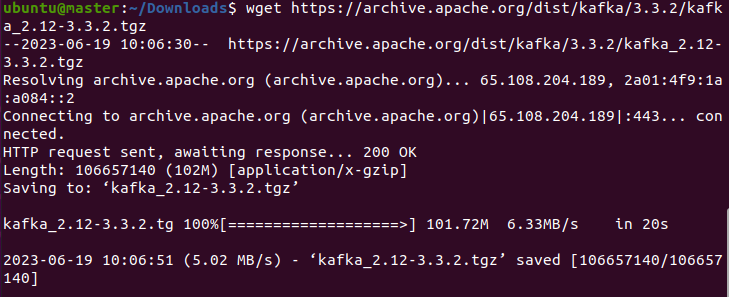

* 압축 해제 및 파일 이동

In [ ]:
# 압축 해제
tar -xf kafka_2.12-3.3.2.tgz

# 파일 이동
sudo mv kafka_2.12-3.3.2 /usr/local/kafka

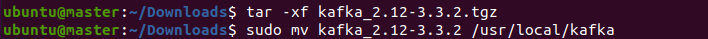

* 사용자 환경변수 등록

In [ ]:
# 환경변수 등록
echo "KAFKA_HOME=/usr/local/kafka" >> ~/.bashrc
source ~/.bashrc

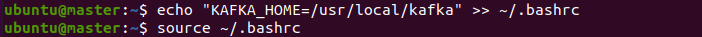

* $KAFKA_HOME/config/zookeeper.properties 파일 수정
* Zookeeper의 zoo.cfg와 동일하게 수정

In [ ]:
# zookeeper.properties 파일 수정
cd $KAFKA_HOME/config/

# 기존 zookeeper.properties는 zookeeper.sample.properties로 변경
mv zookeeper.properties zookeeper.sample/properties

# 새로 zookeeper.properties 파일을 만들어 다음의 파라미터값 입력
echo "tickTime=2000" > /usr/local/kafka/config/zookeeper.properties
echo "dataDir=/usr/local/zookeeper/data" >> /usr/local/kafka/config/zookeeper.properties
echo "clientPort=2181" >> /usr/local/kafka/config/zookeeper.properties

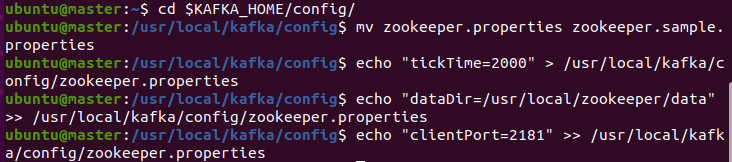

* $KAFKA_HOME/config/server.properties 파일 수정

In [ ]:
# server.properties 파일 수정
mv server.properties server.sample.properties

# 새로 server.properties파일을 만들어 다음의 파라미터값 입력
echo "broker.id=1" > /usr/local/kafka/config/server.properties
echo "listeners=PLAINTEXT://:9092" >> /usr/local/kafka/config/server.properties
echo "advertised.listeners=PLAINTEXT://master:9092" >> /usr/local/kafka/config/server.properties
echo "offsets.topic.num.partitons=1" >> /usr/local/kafka/config/server.properties
echo "offsets.topic.replication.factor=1" >> /usr/local/kafka/config/server.properties
echo "log.dirs=/usr/local/kafka/logs" >> /usr/local/kafka/config/server.properties
echo "zookeeper.connect=master:2181" >> /usr/local/kafka/config/server.properties

* broker.id: 각 서버에서 실행할 kafka broker의 고유id값
* listeners: kafka 브로커가 클라이언트 연결을 수신하는 네트워크 인터페이스와 포트를 지정<br>
    - 클라이언트와 통신하기 위한 방법을 브로커에 알려주는 역할
    - PROTOCOL://hostname:port의 형식
    - hostname이 비어있는 경우, 모든 네트워크 인터페이스에서 수신 대기
    - PLAINTEXT 프로토콜은 클라이언트와 브로커 간 통신을 암호화 하지 않고 평문(plain text)형태로 발송한다는 것<br>
        -> 보안상 문제가 될 수 있으나, 실습상의 편의를 위해 사용<br>
        -> 보안이 필요한 경우 SSL://9093과 같이 SSL프로토콜을 사용하여 SSL/TLS를 통한 암호화 가능
* advertised.listeners: 브로커가 자신을 다른 브로커나 클라이언트에 어떻게 알릴지 결정하는 설정
     - PROTOCOL://hostname:port의 형태로 설정
* log.dirs: Kafka의 로그 데이터를 저장 관리하는 디렉토리 경로 지정
* zookeeper.connect: Kafka의 고가용성을 보장하기 위하여 가용한 Zookeeper서버 주소를 연결문자열로 나열

* 중간에 콤마 오타는 수정하여 다시 입력했음

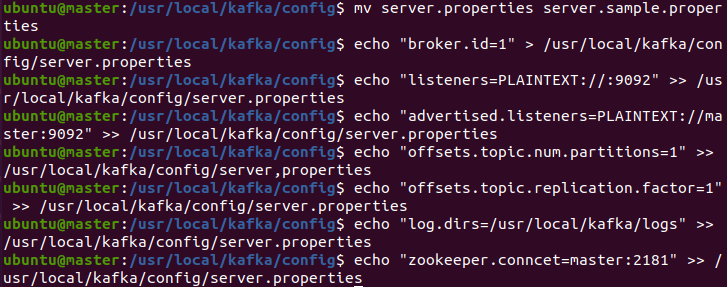

* server.properties 파일을 열어 오타 확인

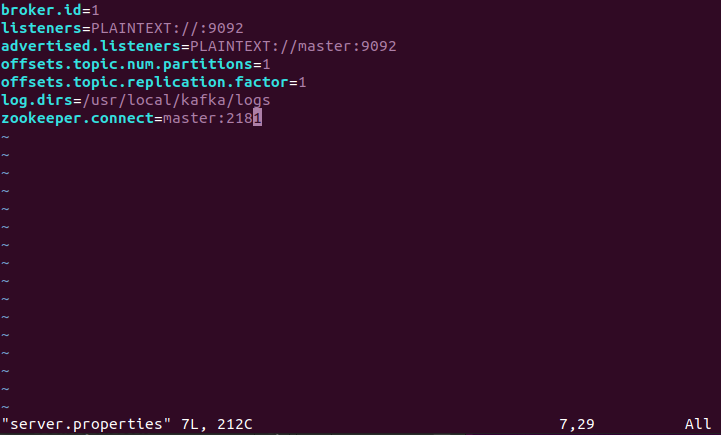

* server.properties의 log.dirs에서 정의한 디렉토리 생성

In [ ]:
# 상위 디렉토리로 이동
cd..

# logs폴더 생성
mkdir logs

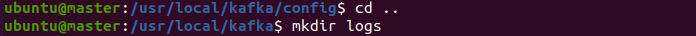

## 4. Zookeeper & Kafka 실행 및 종료

### Kafka에서 Zookeeper 및 Kafka 실행

* master에서 zookeeper 서버 구동

In [ ]:
# master의 zookeeper 서버 구동
$KAFKA_HOME/bin/zookeeper-server-start.sh $KAFKA_HOME/config/zookeeper.properties

* master에서 새 터미넣을 열어 각 zookeeper서버 상태 확인

In [ ]:
# master 서버 상태 확인
$ZOOKEPPER_HOME/bin/zkServer.sh status

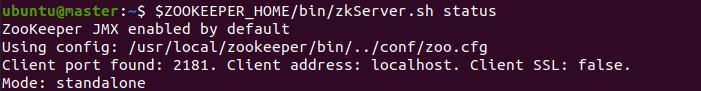

* master에서 kafka 실행

In [ ]:
# 또 다른 터미널 창을 열어 kafka 실행
$KAFKA_HOME/bin/kafka-server-start.sh $KAFKA_HOME/config/server.properties

* master에서 kafka서버 상태 확인

In [ ]:
# kafka서버 상태 확인
netstat -nltp | grep 9092

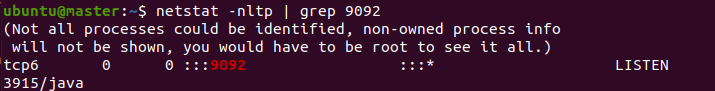

### Kafka에서 zookeeeper 및 kafka서버 종료

* $KAFKA_HOME/bin/안에 있는 zookeeper-server-stop.sh파일과 kafka-server-stop.sh 파일 실행

In [ ]:
# master에서 실행
$KAFKA_HOME/bin/kafka-server-stop.sh
$KAFKA_HOME/bin/zookeeper-server-stop.sh

# Kafka 활용하기

## 1. Kafka 활용 기초

### Topic 생성
* $KAFKA_HOME/bin/kafka-topics.sh스크립트에서 --create옵션 사용
* Kafka Topic들을 관리하기 위한 명령형 인터페이스
* 스크립트를 사용하여 Topic생성, 삭제, 수정, 조회 가능

In [ ]:
$KAFKA_HOME/bin/kafka-topics.sh -- create --bootstrap-server master:9092 --replication-factor 1 --partitions 1 --topic testTopic

* --bootstrap-server: Kafka브로커의 주소 지정
* --replication-factor: Topic에 저장하는 메시지의 복제 수 지정
* --partitions: Topic 내 파티션 개수 지정
* --topic: Topic의 이름 지정

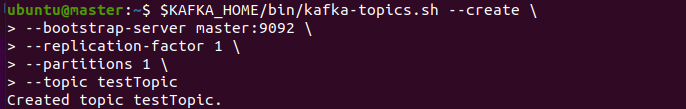

### Topic 목록 조회
* --list옵션 사용

In [ ]:
$KAFKA_HOME/bin/kafka-topics.sh --list --bootstrap-server master:9092

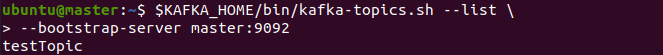

### Topic 정보 조회
* --describe옵션 사용

In [ ]:
$KAFKA_HOME/bin/kafka-topics.sh --describe --bootstrap-server master:9092 --topic testTopic

* config항목 내용
    - Topic: 해당 Topic의 이름
    - Partition: Topic내 존재하는 각 파티션 번호
    - Replicas: 각 파티션의 복제본이 저장된 브로커 ID목록(예시에서는 Topic 생성 시 ReplicationFactor = 1을 설정)
    - Isr: 'In-Sync Replicas'의 약자로, 현재 파티션의 리더와 동기화중인 브로커의 목록

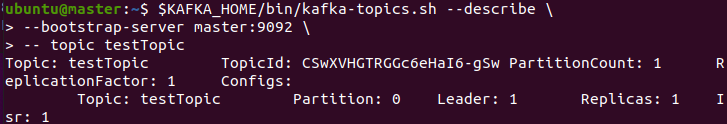

### Topic삭제
* --delete옵션 사용

In [ ]:
$KAFKA_HOME/bin/kafka-topics.sh --delete --bootstrap-server master:9092 --topic testTopic

### Producer에서 메시지 생성
* $KAFKA_HOME/bin/kafka-console-producer.sh 스크립트 사용
* 메시지를 생성하여 토픽에 직접 전송하기 위하여 사용하는 간단한 유틸리티
* 주로 학습, 테스트, 디버깅, 간단한 실험에 사용
* 프로그램이나 스크립트에서 메시지를 생성하여 브로커로 전송하기 위해서는 Producer API를 사용한 프로그래밍 필요

In [ ]:
# 명령어 실행 후 출력되는 '>'다음에 전송하고자 하는 메시지 입력
$KAFKA_HOME/bin/kafka-console-producer.sh --broker-list master:9092 --topic testTopic

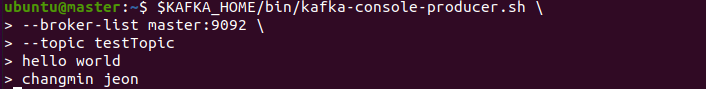

### Consumer에서 메시지 구독
* 새 터미널을 열어 $KAFKA_HOME/bin/kafka-console-consumer.sh 스크립트 사용
* Topic에서 메시지를 구독(=소비, consume)하고 콘솔에 입력

In [ ]:
$KAFKA_HOME/bin/kafka-console-consumer.sh --bootstrap-server master:9092 --topic testTopic

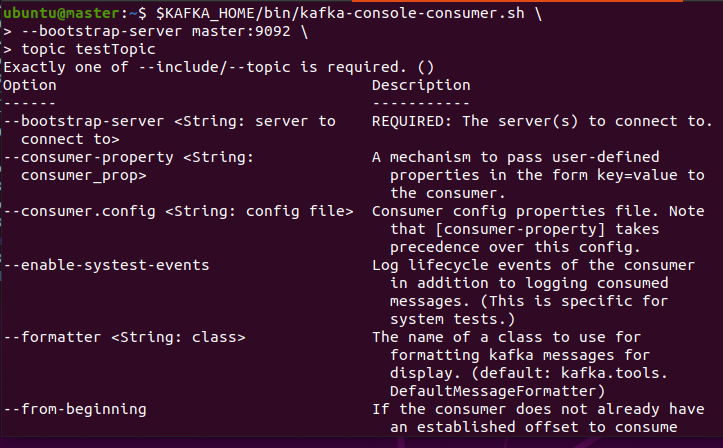

* 위의 명령어는 실행 후 입력되는 메시지부터 구독이 시작된다.
* Topic의 처음부터 메시지를 구독하고자 하는 경우 --from-beginning옵션 사용

In [ ]:
# --from-beginning옵션 사용한 경우
$KAFKA_HOME/bin/kafka-console-consumer.sh --bootstrap-server master:9092 --topic testTopic --from beginning

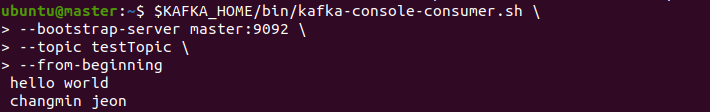

* 프로듀서에 메시지를 입력했을 때, 브로커의 토픽을 거쳐 컨슈머에 출력이 되는 것을 확인할 수 있다.

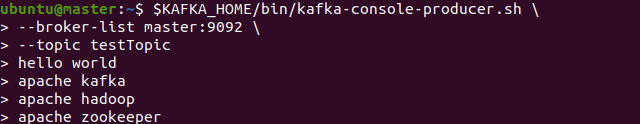

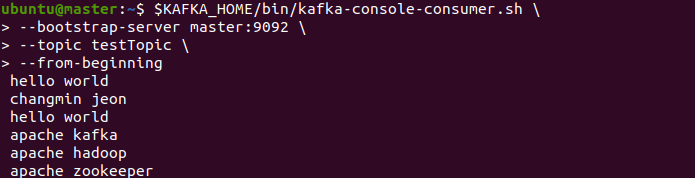

## 2. Spark와 Kafka 연동

* Kafka를 Spark Streaming의 스트리밍 소스/링크로 사용 가능
* Kafka를 스트리밍 소스로 활용하여 입력되는 문자열에 대하여 word count를 수행하는 프로그램 작성
* pyspark 실행

In [ ]:
# 연동을 통해 pyspark 실행 확인
$SPARK_HOME/bin/pyspark --master yarn --deploy-mode client --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.4.0 --verbose

* --master: spark의 리소스 매니저로 YARN을 사용
* --deploy-mode: 분포 모드를 client로 설정
* --packages: pyspark에서 사용할 외부 라이브러리 등록
    - Apache의 의존성 관리 도구 Ivy 사용
    -  --package옵션은 아래 라이브러리를 구분자 ':'를 사용해 연결해서 지정, 실행 시 ~/.ivy2 디렉토리에 해당 라이브러리 다운로드
    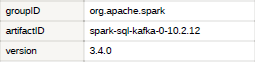
    - 실습에서 사용하고 있는 spark와 kafka는 scala 2.12버전 기반이며, kafka broker는 0.10, spark는 3.4x버전이므로 위 버전의 라이브러리 사용
    - 클러스터 모드인 경우 해당 옵션을 실행하면 모든 노드들에 해당 라이브러리를 자동으로 설치
* verbose: pyspark 실행 시 정보 표시
    

### Kafka 라이브러리
* Spark에서 kafka를 사용하려면 2가지의 라이브러리 필요
* Kafka clients: Spark 애플리케이션에서 Kafka 서버와 통신하는데 필요한 클래스와 함수 제공
* Spark Streaming Kafka: Kafka 소스에서 스트리밍 데이터를 읽고, Kafka 싱크로 데이터를 쓰는 기능 제공
* --verbose옵션을 사용하여 확인할 수 있는(pyspatk 시작 시 메시지 출력) Java Classipath에 아래와 같이 kafka관련 라이브러리들이 로드 되어야 한다.

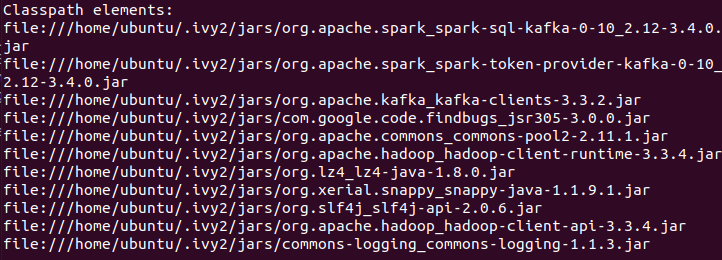

* spark-sql-kafka-0-10_2.12:3.4.0에 kafka-clients-3.3.2가 포함됨

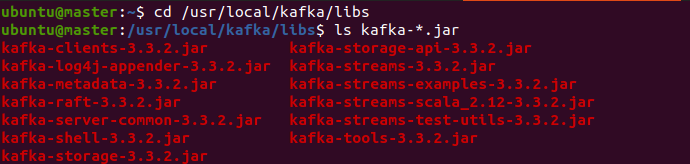

* 재부팅 후, Hadoop, Kafka, Spark순으로 연결

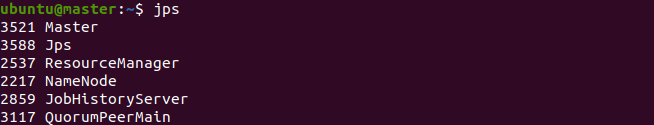

* HDFS에 체크포인트를 저장할 저장소 생성

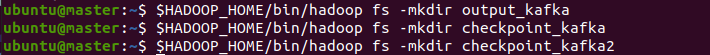

* 저장소 생성 확인

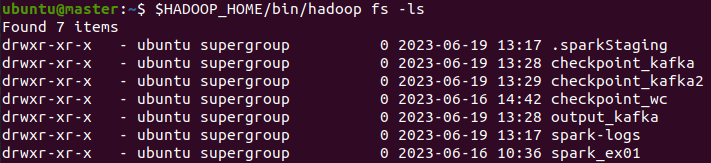

* 카프카 시작, 토픽 생성

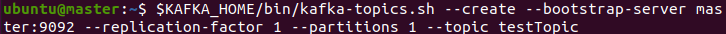

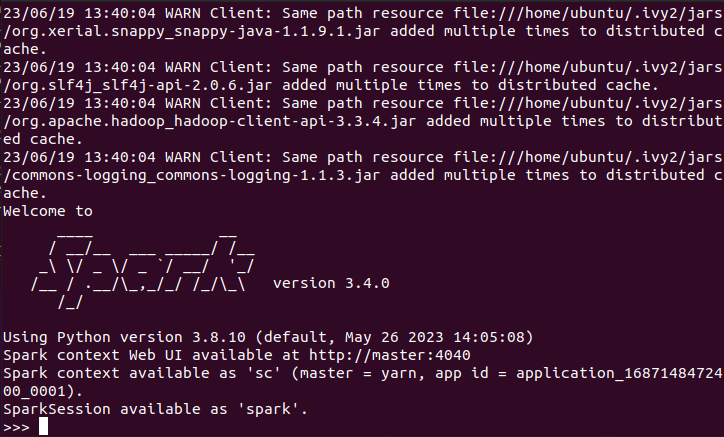

### 콘솔에 결과 출력
* kafka를 입력 소스로 지정

In [ ]:
kafkaStream = spark\
    .readStream\
    .format("kafka")\
    .option("kafka.bootstrap.servers", "master:9092")\
    .option("subscribe", "testTopic")\
    .load()

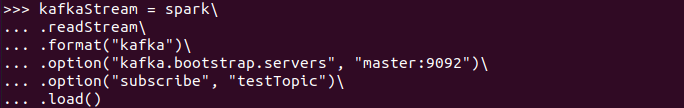

* kafka를 통해 생성되는 Spark Streaming DataFrame은 기본적으로 다음과 같은 스키마를 지닌다.

In [ ]:
# 집계가 적용되지 않은 streaminf DataFrame은 complete 모드가 지원되지 않음
test1_console = kafkaStream.writeStream\
    .outputMode("append")\
    .format("console")\
    .start()

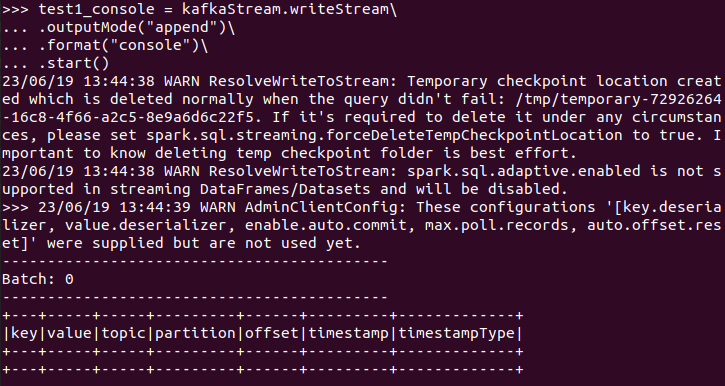

* producer.sh를 통해 데이터를 발행하여 아래와 같이 append된 데이터를 확인할 수 있다.

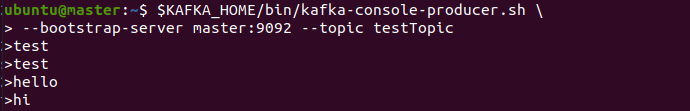

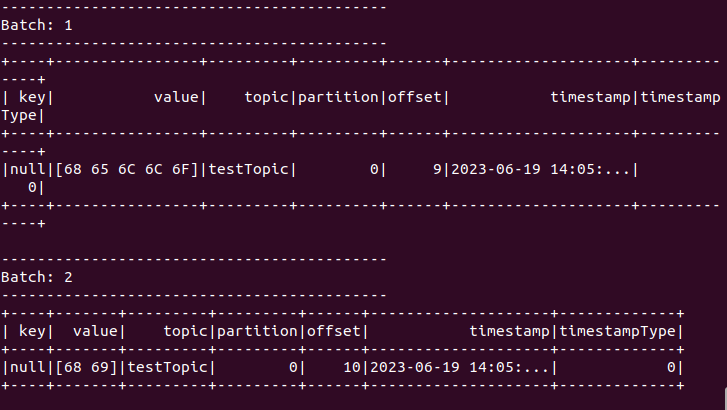

|컬럼 이름|데이터 타입|설명|
|---|---|---|
|key|binary|바이트로 구성된 레코드의 키 데이터|
|value|binary|바이트로 구성된 레코드의 값 데이터|
|topic|string|레코드가 있었던 Kafka의 토픽으로, 여러 토픽에서 값을 읽었을 경우 유용|
|partition|int|레코드가 있었던 Kafka 토픽의 파티션|
|offset|long|레코드의 오프셋 값|
|timestamp|long|레코드와 관계된 타임스탬프|
|timestampType|int|레코드 타임스탬프의 타입|

* DataFrame의 value 컬럼을 문자열로 변환하고, 공백(" ")에 따라 단어로 분할한 후 개별 행으로 나눠 word라는 별칭으로 컬럼 생성

In [ ]:
from pyspark.sql.functions import *

# 위의 표에서 보듯, 기존의 value컬럼은 binary타입
# 따라서 그대로는 연산이 불가능하므로 SQL연산자인 CAST(데이터 형식 변환)을 사용하여
# value컬럼을 문자열로 변환
words = kafkaSream.selectExpr("CAST(value AS STRING)")\
    .select(explode(split("value", " ")).alias("word"))

* explode: 배열 혹은 컬럼의 요소들을 개별 행으로 분해하여 변환
* 각 요소들은 개별 행으로 확장되어 원래 DataFrame의 row수가 증가

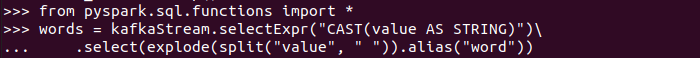

* 그룹화를 통해 단어별로 빈도수 산출

In [ ]:
# 단어별로 빈도수 산출
wordCounts = words.groupBy("word").count()

* 스트리밍 싱크에 대한 코드 작성

In [ ]:
query_console = wordCounts.writeStream\
    .outputMode("complete")\
    .format("console")\
    .trigger(processingTime="15 second")\
    .option("checkpointLocation", "hdfs://master:9000/usr/hadoop/checkpoint_kafka")\
    .start()

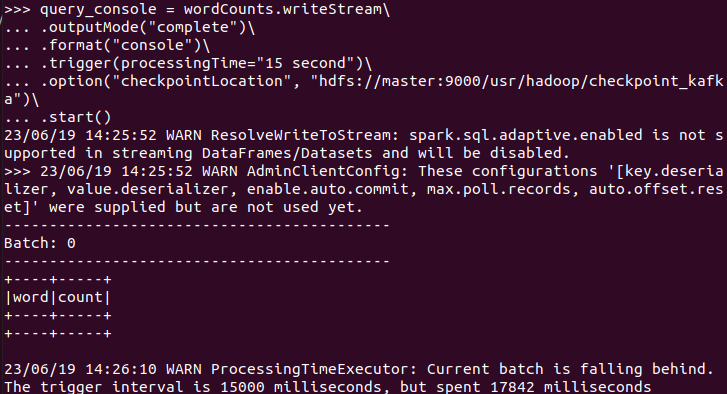

* Kafka 프로듀서를 통해 텍스트 입력 시 다음과 같은 출력 확인 가능

In [ ]:
$KAFKA_HOME/bin/kafka-console-producer.sh --bootstrap-server master:9092 --topic testTopic

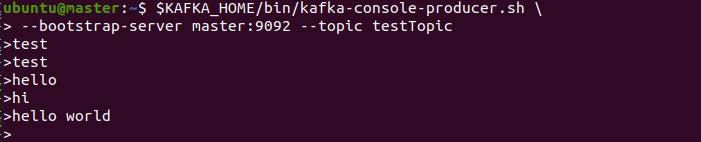

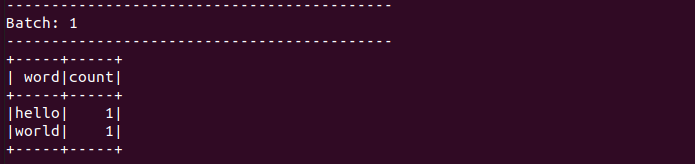

### 이벤트 시간 처리
* Spark Streaming은 스트리밍 데이터 처리를 위해 두 가지 시간 개념을 사용
* 이벤트 시간(Event Time)
    - 데이터가 생성 또는 발생한 실제 시간
    - ex. 센서 데이터에서 센서가 감지를통해 데이터를 생성한 시간
    - 데이터의 본질적인 특성이며, 데이터의 시간 순서와 연관됨
    - 실습에선 kafkaStream에 포함되어 있는 timestamp컬럼이 이에 해당
* 처리 시간(Processing Time)
    - 스트리밍 데이터 처리 엔진이 데이터를 수신하고 처리하는 시간
    - ex. 센서 데이터가 Spark Streaming에 전달되어 처리되는 시간
    - 스트리밍 애플리케이션에서 데이터를 처리하기 위한 기준 시간으로 사용
    - 실습에선 trigger()메소드의 processingTime 파라미터가 이에 해당
    

### 시간 기반 윈도우 연산
* 이벤트 시간을 기준으로 스트리밍 데이터를 특정 시간 범위로 분할하여 처리하는 기술
* 스트리밍 데이터는 지속적으로 도착하며, 윈도우 연산을 통해 이러한 데이터를 일정한 시간에 따라 그룹화하여 분석/집계를 수행 가능
* 윈도우 연산은 두 가지 시간 간격을 사용하여 윈도우 조절
* 시간 간격(Time Interval)
    - 윈도우의 크기
    - 윈도우가 데이터를 그룹화하는 기준으로 사용
* 슬라이딩 타임(Sliding Time)
    - 윈도우가 슬라이딩하는 간격
    - 윈도우들이 서로 겹치는 정도를 제어
* Spark에서는 실습에서 window()메소드를 사용하여 윈도우 연산 구현
    

### 워터마크 생성
* 네트워크는 불완전하므로 스트리밍 데이터 처리 엔진에 도착하는 데이터가 언제나 이벤트 시간 순서로 들어오는 것은 아니다.
* ex. 한국 본사에서 일본 지사, 미국 지사에서의 데이터를 집계할 시, 미국 지사 데이터의 발생 시간(이벤트 시간)이 일본 지사의 데이터보다 실제로는 더 빨라도 거리로 인해 한국 본사에 있는 집계 시스템에는 늦게 도착할 수 있음
* 이처럼 지연 도착이 발생하는 경우 Spark Streaming은 이를 고려하여 아레 그림과 같이 처리는 원래 윈도우가 처리해야 하는 배치가 아닌 그 이후의 배치에 수행하지만, 원래 있어야 하는 윈도우에 데이터를 갱신

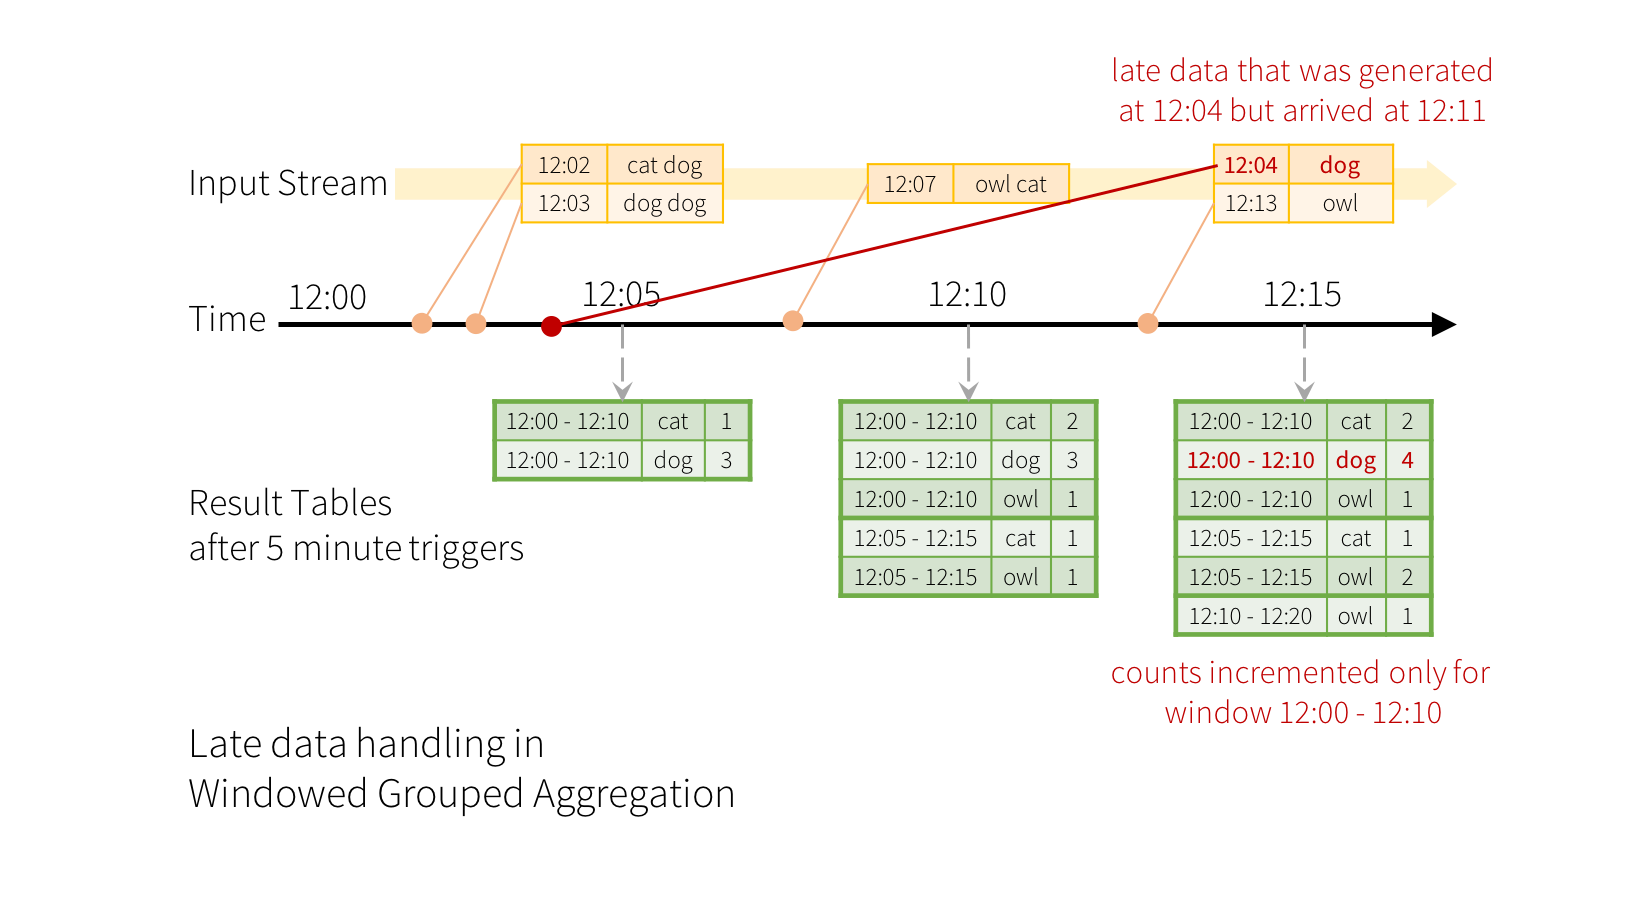

* 하지만 이러한 경우 임계값이 없으면 과거에 들어온 윈도우들의 데이터들이 완겨로디지 못하고 무한이 갱신을 기다려야만 하는 상황이 발생하며, 이러한 데이터들은 계속해서 메모리 점유<br>
-> 스트리밍 엔진이 데이터를 기다려줄 수 있는 한계인 워터마크를 설정하여 이를 해결

* 워터마크를 포함하여 wordCounts변수 재정의
* streaming aggregation이 포함된 streaming DataFrame은 complete모드로 파일 저장이 지원되지 않음<br>
-> append모드를 사용하여 데이터를 저장하며, 이 때 반드시 워터마크가 지정되어 있어야 한다.

In [ ]:
# words streaming DataFrame이 이벤트 시간을 의미하는 eventTime 컬럼을 포함하도록 수정한
# modified_words streaming DataFrame 생성
# kafkaStream에 포함된 timestamp컬럼은 데이터 타입이 long이므로
# 이벤트 시간으로 사용할 수 있도록 데ㅔ이터타입을 timestamp로 변환
modified_words = kafkaStream.selectExpr("CAST(value AS STRING)", "CAST(timestamp AS TIMESTAMP)")\
    .select(explode(split("value", " ")).alias("word"), col("timestamp").alias("eventTime"))

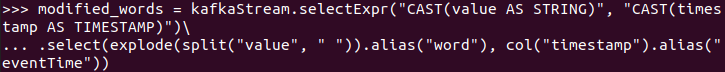

In [ ]:
# 20초 시간 간격의 텀블링 윈도우 생성
# 임계값30초의 워터마크 생성
modified_wordCounts = modified_words.withWatermark("eventTime", "30 seconds")\
    .groupBy(window("eventTime", "20 seconds"), "word")\
    .count()

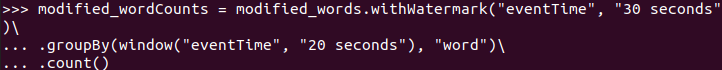

* 스트리밍 싱크 코드 작성

In [ ]:
# 20초의 처리시간 마다 streaming DaraFrame을 조회하여
# 새로 추가된 데이터가 (append mode)워터마크 시간이 지나 완결되면
# parquet파일로 저장하는 싱크 생성
query_parquet = modified_wordCounts.writeStream\
    .outputMode("append")\
    .format("parquet")\
    .trigger(processingTime="20 second")\
    .option("path", "hdfs://master:9000/user/ubuntu/checkpoint_kafka2")\
    .start()

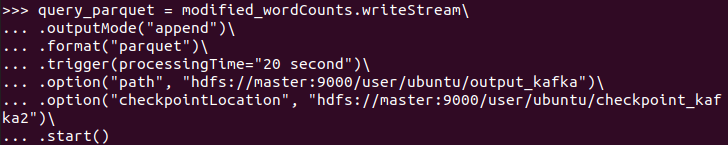

* 파일확인: 해당 윈도우가 완결되지 않으면 데이터가 저장되지 않아 빈 DataFrame이 출력됨에 유의

In [ ]:
test_df = spark.read.foramt("parquet")\
    .load().load("hdfs://master:9000/user/ubuntu/output_kafka/part-00158-52dce0fd-0485-4b25-bcf9-a22203b57735-c000.snappy.parquet")

test_df.show()

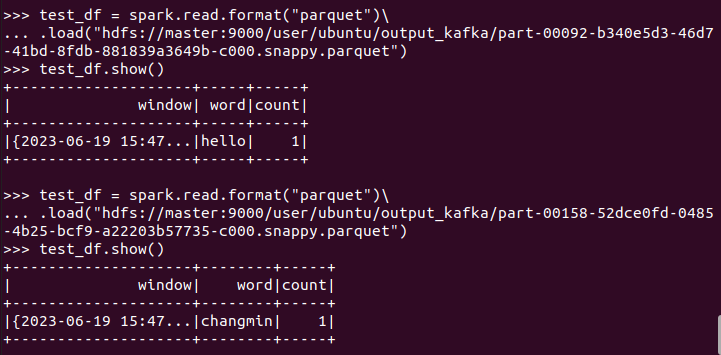

# MLlib, Spark ML

## 1. MLlib, Spark ML 개요

* Spark에서 머신러닝 작업을 수행하는 것은 다음의 이점을 지닌다.
    - Spark의 분산 처리 능력을 활용해 매우 큰 규모의 데이터셋에서도 빠른 속도로 머신러닝 알고리즘을 훈련 및 적용할 수 있다.
    - 데이터 수집, 정제, 분석까지 머신러닝 작업의 대부분을 한 곳에서 수행할 수 있도록 통합 플랫폼 제공
    - 머신러닝 파이프라인(pipeline)기능을 제공해 머신러닝과 관련된 모든 연산 작업을 하나로 모아 마치 단일 연산처럼 한 번에 처리 가능
* Spark에는 두 가지 머신러닝 패키지가 존재
* spark mllib: RDD API를 기반으로 하는 기존의 머신러닝 API
* spark.ml: DataFrame을 기반으로 하는 최신 API
    - spark.mllib보다 더욱 편리하고 직관적인 API제공
    - Spark의 데이터 처리 기능과 통합되어 효율적인 데이터 파이프라인 구축 가능
    - spark.mllib보다는 spark.ml사용 권장

## 2. Spark ML 실습(Decision Tree)

### Numpy 설치

In [ ]:
# numpy 설치전에 pip 먼저 설치를 해줘야 한다
sudo apt install python3-pip

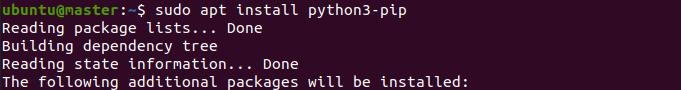

In [ ]:
# numpy 설치
pip install numpy

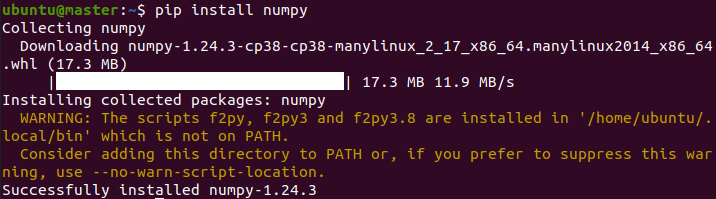

In [ ]:
# Downloads폴더로 이동하여 iris데이터 다운로드
wget https://archive.ics.uci.edu/static/public/53/iris.zip

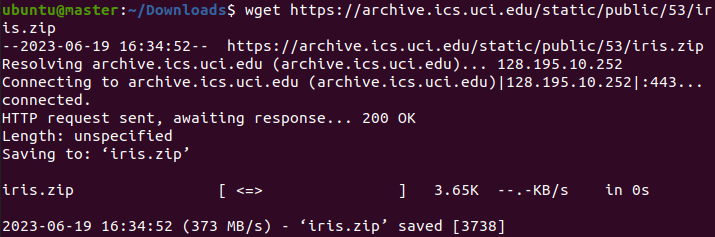

In [ ]:
# 압축 해제
unzip iris.zip

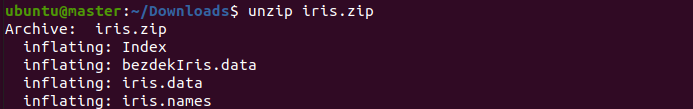

In [ ]:
# HDFS에 업로드를 위해 디렉토리 생성
$HADOOP_HOME/bin/hadoop fs -mkdir test_dataset

# HDFS에 업로드
$HADOOP_HOME/bin/hadoop fs -put iris.data test_dataset/iris.data

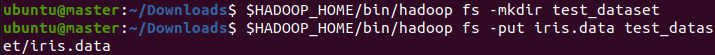

* 라이브러리 호출

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

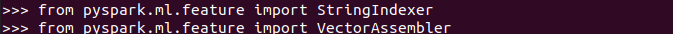

* 데이터 로드

In [ ]:
iris_df = spark.reaf.format("csv")\
    .option("inferSchema", "true")\
    .load("hdfs://amster:9000/user/ubuntu/test_dataset/iris_data")

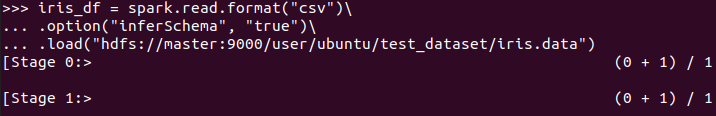

* 데이터 전처리

In [ ]:
# Feature들(_c0, _c1, _c2, _c3)을 단일 벡터화
feature_columns = iris_df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(iris_df)
assembled_data.show(5)

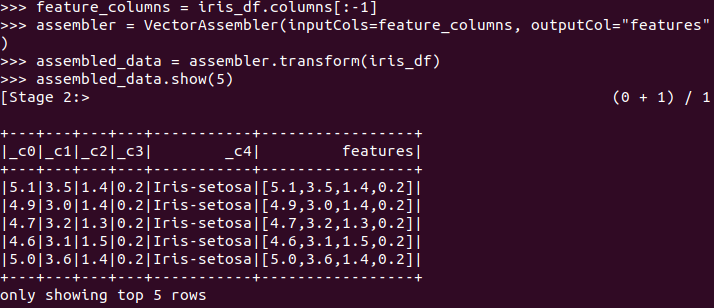

In [ ]:
# assembled_data에 레이블 컬럼(_c4)도 문자열 인덱싱하여 추가
label_indexer = StringIndexer(inputCol="_c4", outputCol="label")
indexed_data = label_indexer.fit(assembled_data).transform(assembled_data)
indexed_data.show(5)

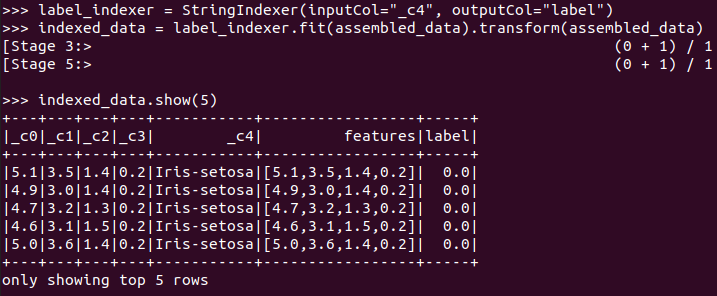

* 모델 생성 및 학습

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# DecisionTree 모델 생성 및 학습
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model = dt.fit(indexed_data)

# 새로운 데이터 생성
new_data = spark.crateDataFrame([(5.1, 3.5, 1.4, 0.2)], ["_c0", "_c1", "_c2", "_c3"])

# 새로운 데이터의 feature들을 단일 벡터화
assembled_new_data = assembler.tranform(new_data)

# 예측수행
predictions = model.transform(assembled_new_data)

# 예측 결과 확인
predictions.select("_c0", "_c1", "_c2", "_c3", "prediction").show()

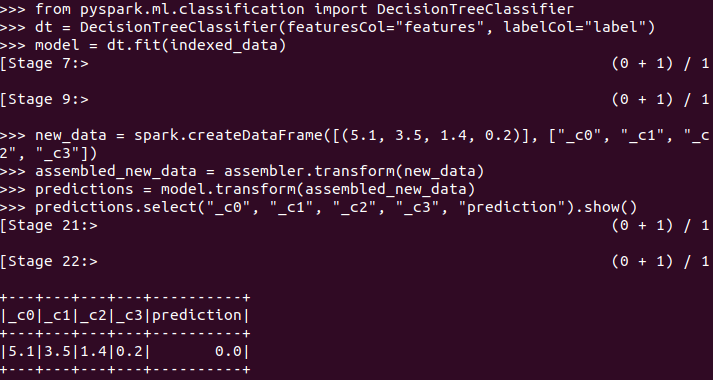